## Sentiment Analysis - Fine-tuning a BERT model on the IMDB Dataset

The BERT Base model is trained on the IMDB Movie Review dataset to make positive and negative sentiment classification predictions.  It also serves the model for inference via TensorFlow serving.

BERT (Bidirectional Encoder Representations Transformer) uses Masked Language Model (MLM) to look at all tokens in the sentence not just the preceeding ones.  It uses an encoder only Transformer as opposed to an encoder/decoder architecture used in T5.  BERT was developed by Google AI Language (Jacob Devlin et al) and is used in Google Search. RoBERTa developed by Facebook AI and DeBERTa developed by Microsoft are also examples of top performing variants of BERT on the GLUE and SuperGlue NLP benchmarks. 

This Notebook was run on Google Colab using a GPU and high memory

This example is adapted from several examples listed below:

https://www.tensorflow.org/official_models/fine_tuning_bert

https://www.tensorflow.org/tutorials/text/classify_text_with_bert

https://www.tensorflow.org/tfx/tutorials/serving/rest_simple


In [ ]:
% pip install -q tensorflow-text

In [ ]:
% pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

**Get the BERT Model & Preprocess Model from the Tensorflow Model Hub**

This example uses the BERT Base model but its easy to swap it out for other variants such as the BERT Large, which is slightly more accurate and significantly slower.

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**The data**

For this example we used the IMDB dataset from TFDS.
https://www.tensorflow.org/datasets/catalog/imdb_reviews 

This dataset is not set up so that it can be directly fed into the BERT model, so this section also handles the necessary preprocessing.

Get the dataset from TensorFlow Datasets and examine the data

In [ ]:
imdb, info = tfds.load('imdb_reviews', with_info=True,
                       batch_size=-1)

In [ ]:
list(imdb.keys())

['test', 'train', 'unsupervised']

In [ ]:
# The info object describes the dataset and it's features:
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})

In [ ]:
# The two classes are:
info.features['label'].names

['neg', 'pos']

In [ ]:
# Print a training example:
imdb_train = imdb['train']
imdb_val = imdb['test']
imdb_test = imdb['unsupervised']

for key, value in imdb_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

label    : 0
text     : b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [ ]:
print(imdb_val['text'])

tf.Tensor(
[b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden pri

Optimize Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
val_size = 15000
test_size = 10

In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((imdb_train['text'], imdb_train['label']))
train_ds = raw_train_ds.batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.data.Dataset.from_tensor_slices((imdb_val['text'][:val_size], imdb_val['label'][:val_size]))
val_ds = raw_val_ds.cache().batch(batch_size, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

raw_eval_ds = tf.data.Dataset.from_tensor_slices((imdb_val['text'][val_size:], imdb_val['label'][val_size:]))
eval_ds = raw_train_ds.cache().batch(batch_size, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.data.Dataset.from_tensor_slices((imdb_test['text'][:test_size], imdb_test['label'][:test_size]))
test_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for review, label in zip(text_batch[:5], label_batch[:5]):
    print(f'Movie Review has sentiment {label} for input text {review}')

Movie Review has sentiment 0 for input text b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Movie Review has sentiment 0 for input text b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

**Preprocess the data**

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


The 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).

The input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

**Use the BERT Model**

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.9216989  -0.39353535 -0.5393206   0.68256295  0.43848675 -0.14021207
  0.8774716   0.26043403 -0.63113207 -0.99996567 -0.26320213  0.851054  ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451521  0.2514171   0.19074959 ... -0.24845052  0.38568553
   0.13291009]
 [-0.59478754 -0.39420435  0.25245735 ... -0.76946807  1.1564162
   0.32475716]
 [ 0.00641596 -0.15766442  0.54610294 ... -0.1745113   0.6028951
   0.426723  ]
 ...
 [ 0.21948361 -0.20927043  0.5386834  ...  0.24693483  0.18250942
  -0.44426998]
 [ 0.01080248 -0.44553173  0.35990965 ...  0.31722686  0.23562762
  -0.6307051 ]
 [ 0.29321116 -0.1058189   0.6114756  ...  0.20745769  0.14494625
  -0.35353318]]


**Define your model**

Create a very simple fine-tuned model consisting of:

*   The Preprocessing Model
*   The Selected BERT model
*   Dense Layer
*   Dropout Layer

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Quick sanity test

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5593434]], shape=(1, 1), dtype=float32)


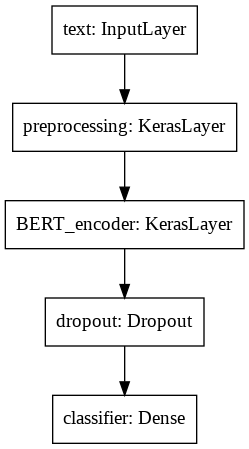

In [ ]:
tf.keras.utils.plot_model(classifier_model)


**Loss function**

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use losses.BinaryCrossentropy loss function.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

**Optimizer**

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

**Compile & Train Model**

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
781/781 [==============================] - 551s 682ms/step - loss: 0.4946 - binary_accuracy: 0.7079 - val_loss: 0.3080 - val_binary_accuracy: 0.8803
Epoch 2/5
781/781 [==============================] - 531s 680ms/step - loss: 0.2609 - binary_accuracy: 0.8900 - val_loss: 0.3206 - val_binary_accuracy: 0.8867
Epoch 3/5
781/781 [==============================] - 532s 681ms/step - loss: 0.1409 - binary_accuracy: 0.9506 - val_loss: 0.4201 - val_binary_accuracy: 0.8878
Epoch 4/5
781/781 [==============================] - 532s 681ms/step - loss: 0.0686 - binary_accuracy: 0.9800 - val_loss: 0.5659 - val_binary_accuracy: 0.8876
Epoch 5/5
781/781 [==============================] - 532s 681ms/step - loss: 0.0368 - binary_accuracy: 0.9897 - val_loss: 0.6272 - val_binary_accuracy: 0.8882


**Evaluate the model**

Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
print(eval_ds)

<PrefetchDataset shapes: ((32,), (32,)), types: (tf.string, tf.int64)>


In [ ]:
loss, accuracy = classifier_model.evaluate(eval_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

781/781 [==============================] - 173s 222ms/step - loss: 0.0124 - binary_accuracy: 0.9975
Loss: 0.012366879731416702
Accuracy: 0.9974792003631592


**Plot the accuracy and loss over time**

Based on the History object returned by model.fit(). You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


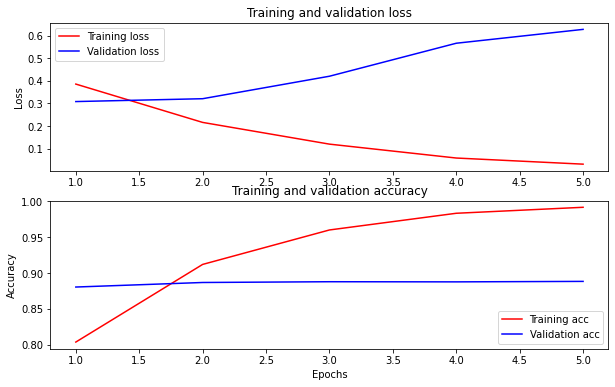

In [43]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Export the Model for Future Use**

In [44]:
version = 1
dataset_name = 'imdb'
cwd = os.getcwd()

export_path = '{}/{}_bert'.format(cwd, dataset_name.replace('/', '_'))
saved_model_path = export_path + '/' + str(version)
print(f'export_path={export_path}, saved_model_path={saved_model_path}')

export_path=/content/imdb_bert, saved_model_path=/content/imdb_bert/1


In [45]:
classifier_model.save(saved_model_path, include_optimizer=True, overwrite=True)

In [46]:
# Reload the model
reloaded_model = tf.saved_model.load(saved_model_path)

In [47]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.998667
input: The movie was great!           : score: 0.997542
input: The movie was meh.             : score: 0.135683
input: The movie was okish.           : score: 0.001024
input: The movie was terrible...      : score: 0.000702

Results from the model in memory:
input: this is such an amazing movie! : score: 0.998667
input: The movie was great!           : score: 0.997542
input: The movie was meh.             : score: 0.135683
input: The movie was okish.           : score: 0.001024
input: The movie was terrible...      : score: 0.000702



**Use TF Serving**

TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments.

Servables are the core abstraction in TensorFlow Serving and will represent out model. Apart from that, TF Serving provides Sources, Loaders and Managers that handle the actual serving, loading of new versions and unloading of old versions.

In [48]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.998667
input: The movie was great!           : score: 0.997542
input: The movie was meh.             : score: 0.135683
input: The movie was okish.           : score: 0.001024
input: The movie was terrible...      : score: 0.000702



Another Serving Example

In [49]:
% ls /content/imdb_bert/1/

assets/  saved_model.pb  variables/


In [50]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/c

In [51]:
! apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.4.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [52]:
%%bash -s "$export_path" --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=imdb_bert \
  --model_base_path=$1 >server.log 2>&1

Starting job # 2 in a separate thread.


In [53]:
! tail server.log

2021-02-19 19:03:20.569409: I tensorflow_serving/model_servers/server.cc:88] Building single TensorFlow model file config:  model_name: imdb_bert model_base_path: /content/imdb_bert
2021-02-19 19:03:20.569695: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2021-02-19 19:03:20.569734: I tensorflow_serving/model_servers/server_core.cc:587]  (Re-)adding model: imdb_bert


In [54]:
!pip install -q requests

In [55]:
import requests
import json

In [56]:
data = json.dumps({"signature_name": "serving_default", "instances": examples})
print(data)

{"signature_name": "serving_default", "instances": ["this is such an amazing movie!", "The movie was great!", "The movie was meh.", "The movie was okish.", "The movie was terrible..."]}


In [57]:
headers = {"content-type": "application/json"}
url = 'http://localhost:8501/v1/models/imdb_bert:predict'

try:
  json_response = requests.post(url, data=data, headers=headers)
  predictions = json.loads(json_response.text)['predictions']
  predictions = tf.sigmoid(predictions)
  print(predictions)
except ValueError:  # includes simplejson.decoder.JSONDecodeError
    print(f'Failed to fetch url {url} or predictions not a list of floating point numbers: {predictions}')

tf.Tensor(
[[9.9866736e-01]
 [9.9754202e-01]
 [1.3568303e-01]
 [1.0240322e-03]
 [7.0240191e-04]], shape=(5, 1), dtype=float32)


In [58]:
print_my_examples(examples, predictions)

input: this is such an amazing movie! : score: 0.998667
input: The movie was great!           : score: 0.997542
input: The movie was meh.             : score: 0.135683
input: The movie was okish.           : score: 0.001024
input: The movie was terrible...      : score: 0.000702

